In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

import datetime

from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [ ]:
df=pd.read_csv('/content/wind_dataset.csv')

In [ ]:
df.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


In [ ]:
df['DATE']=pd.to_datetime(df['DATE'])

<Axes: xlabel='DATE'>

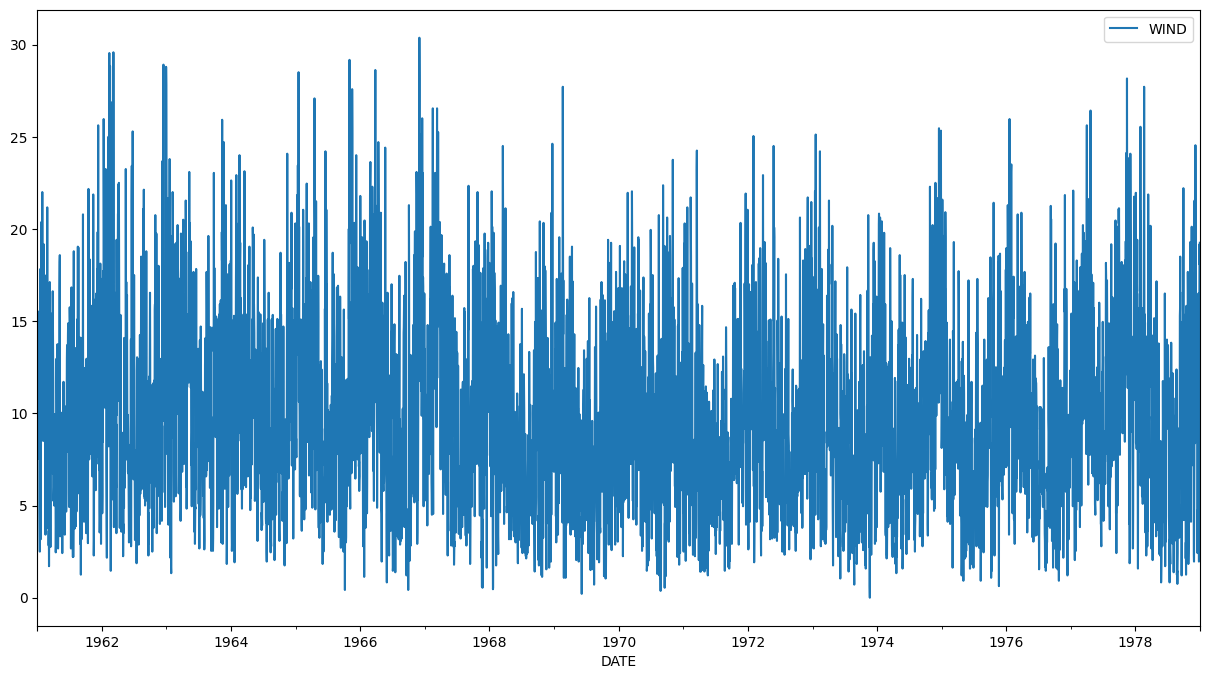

In [ ]:
df.plot(x='DATE',y='WIND',figsize=(15,8))

<Axes: >

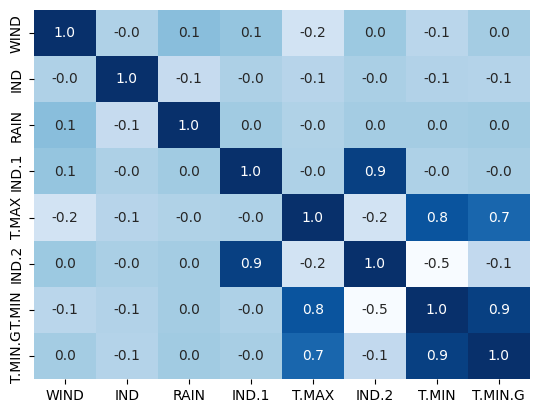

In [ ]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

<Axes: >

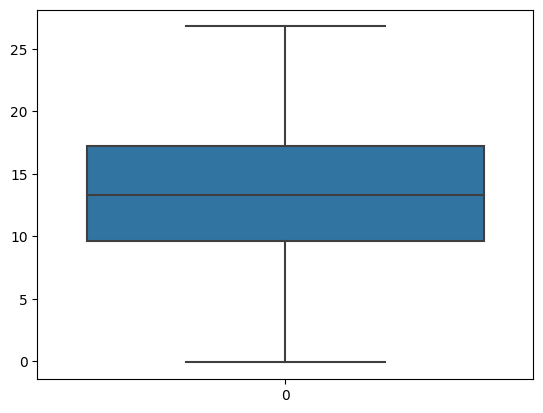

In [ ]:
sns.boxplot(df['T.MAX'])

In [ ]:
df = df.set_index('DATE')

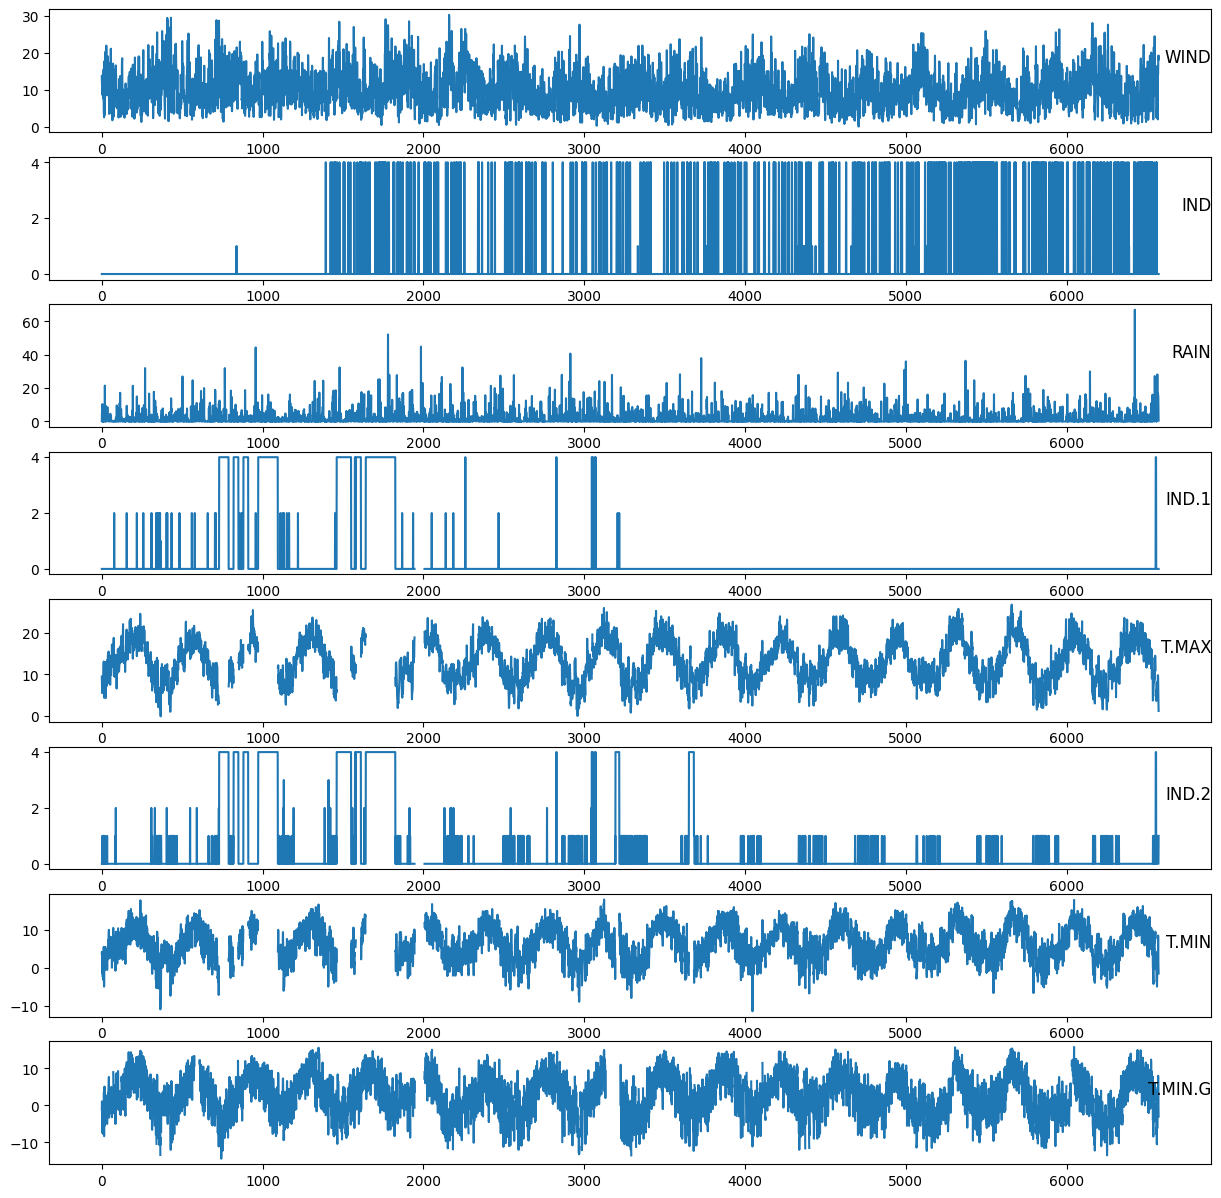

In [ ]:
from matplotlib import pyplot
# load dataset
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3,4, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(15,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [ ]:
df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6574 entries, 1961-01-01 to 1978-12-31
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WIND     6574 non-null   float64
 1   IND      6574 non-null   int64  
 2   RAIN     6574 non-null   float64
 3   IND.1    6574 non-null   float64
 4   T.MAX    6574 non-null   float64
 5   IND.2    6574 non-null   float64
 6   T.MIN    6574 non-null   float64
 7   T.MIN.G  6574 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 462.2 KB


In [ ]:
train_df,test_df = df[1:4601], df[4601:]

In [ ]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [ ]:
def split_series(series, n_past, n_future):

  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 10
n_future = 5
n_features = 8

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 8)]              0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 100),                43600     ['input_1[0][0]']             
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 repeat_vector (RepeatVecto  (None, 5, 100)               0         ['lstm[0][0]']                
 r)                                                                                           

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e2d2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 8)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               [(None, 10, 100),            43600     ['input_2[0][0]']             
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 lstm_3 (LSTM)               [(None, 100),                80400     ['lstm_2[0][0]']              
                              (None, 100),                                                  

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

In [ ]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

62/62 [==============================] - 3s 14ms/step


In [ ]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

WIND
Day  1 :
MAE-E1D1 :  3.0928418485700875, MAE-E2D2 :  3.0871100376941163
Day  2 :
MAE-E1D1 :  3.514934345301832, MAE-E2D2 :  3.502647561121498
Day  3 :
MAE-E1D1 :  3.6335288426241985, MAE-E2D2 :  3.6374081560274116
Day  4 :
MAE-E1D1 :  3.672958518588585, MAE-E2D2 :  3.6812383041946544
Day  5 :
MAE-E1D1 :  3.7120622078942787, MAE-E2D2 :  3.7266172108302134


IND
Day  1 :
MAE-E1D1 :  0.8349312618717117, MAE-E2D2 :  0.8020868750480196
Day  2 :
MAE-E1D1 :  0.8314751995772108, MAE-E2D2 :  0.7889489324315584
Day  3 :
MAE-E1D1 :  0.8185482595330784, MAE-E2D2 :  0.7739904033949084
Day  4 :
MAE-E1D1 :  0.8075199167968181, MAE-E2D2 :  0.7623413343585347
Day  5 :
MAE-E1D1 :  0.8032918319585313, MAE-E2D2 :  0.7577528826979851


RAIN
Day  1 :
MAE-E1D1 :  2.2895297538510024, MAE-E2D2 :  2.380602867366587
Day  2 :
MAE-E1D1 :  2.2788787488732916, MAE-E2D2 :  2.395581067594233
Day  3 :
MAE-E1D1 :  2.2987452260347396, MAE-E2D2 :  2.3739806218710773
Day  4 :
MAE-E1D1 :  2.2950255158309307, MAE-E2D2 :